In [4]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('Datasets/NamebyCountry/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('Datasets/NamebyCountry/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

# We’ll end up with a dictionary of lists of names per language, {language: [names ...]}

['Datasets/NamebyCountry/names\\Czech.txt', 'Datasets/NamebyCountry/names\\Dutch.txt', 'Datasets/NamebyCountry/names\\English.txt', 'Datasets/NamebyCountry/names\\French.txt', 'Datasets/NamebyCountry/names\\German.txt', 'Datasets/NamebyCountry/names\\Greek.txt', 'Datasets/NamebyCountry/names\\Irish.txt', 'Datasets/NamebyCountry/names\\Italian.txt', 'Datasets/NamebyCountry/names\\Polish.txt', 'Datasets/NamebyCountry/names\\Portuguese.txt', 'Datasets/NamebyCountry/names\\Scottish.txt', 'Datasets/NamebyCountry/names\\Spanish.txt']
Slusarski


In [5]:
all_categories


['Czech',
 'Dutch',
 'English',
 'French',
 'German',
 'Greek',
 'Irish',
 'Italian',
 'Polish',
 'Portuguese',
 'Scottish',
 'Spanish']

In [6]:
print(category_lines['Polish'][:5])

['Adamczak', 'Adamczyk', 'Andrysiak', 'Auttenberg', 'Bartosz']


In [7]:
#Turning Names into Tensors
import torch
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [8]:
#Creating the Network
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

print(next_hidden)

tensor([[ 0.0088,  0.0130, -0.0079, -0.0821,  0.0038, -0.0507,  0.0173,  0.0288,
         -0.0911,  0.0449,  0.0532,  0.0413, -0.0498,  0.0245,  0.0176, -0.0666,
          0.0313,  0.0265,  0.0255, -0.0218,  0.1388, -0.0522,  0.0607,  0.0994,
         -0.0560,  0.0305,  0.0677,  0.0629, -0.0384, -0.0258, -0.0127,  0.0929,
         -0.0173, -0.0254,  0.0419, -0.0018, -0.0573,  0.1336,  0.0731, -0.0233,
         -0.0537,  0.0234,  0.0569, -0.0618,  0.0233,  0.1189,  0.0360, -0.0170,
         -0.0078, -0.0308,  0.0867,  0.0752,  0.0044,  0.1243,  0.0005, -0.0664,
         -0.0588, -0.0311,  0.0654,  0.0599,  0.0008,  0.0040, -0.0136,  0.0108,
         -0.0247, -0.0166,  0.0650,  0.0594,  0.0081, -0.0275, -0.0354, -0.0771,
         -0.1066,  0.0317, -0.0249,  0.0433,  0.0155, -0.0888, -0.0854,  0.1413,
         -0.0851, -0.0908,  0.0329,  0.0043, -0.0804, -0.0551,  0.0618,  0.0171,
         -0.0639, -0.1042,  0.1070, -0.1260, -0.0989, -0.1083,  0.0308, -0.0062,
         -0.0078,  0.0190, -

In [10]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)
#output is a <1 x n_categories> 
output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.4693, -2.3503, -2.4047, -2.4966, -2.5374, -2.5177, -2.4962, -2.4520,
         -2.5566, -2.5823, -2.4192, -2.5643]], grad_fn=<LogSoftmaxBackward>)


In [11]:
#Preparing for Training
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Dutch', 1)


In [12]:
#training example (a name and its language):
import torch.nn as nn
import random
from torch.autograd import Variable

def random_training_pair():                                                                                                               
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)


category = Scottish / line = Henderson
category = English / line = Bramley
category = Dutch / line = Hout
category = French / line = Forestier
category = Italian / line = Filippi
category = Irish / line = Madaidhin
category = Polish / line = Kava
category = French / line = Victors
category = Czech / line = Tomasek
category = Polish / line = Skala


In [13]:
#loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.
criterion = nn.NLLLoss()

In [14]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [15]:
import time
import math

n_iters = 200000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

..\torch\csrc\utils\python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


5000 2% (0m 11s) 2.0949 Araujo / Italian ✗ (Portuguese)
10000 5% (0m 20s) 2.3685 Oxenham / Scottish ✗ (English)
15000 7% (0m 30s) 1.3351 Eoin / Irish ✓
20000 10% (0m 39s) 2.3196 Spijker / German ✗ (Dutch)
25000 12% (0m 50s) 1.9336 Hout / French ✗ (Dutch)
30000 15% (1m 0s) 1.7748 Thom / Scottish ✗ (English)
35000 17% (1m 10s) 0.3592 Veen / Dutch ✓
40000 20% (1m 19s) 0.3998 Nepi / Italian ✓
45000 22% (1m 28s) 0.8083 Gehring / German ✓
50000 25% (1m 38s) 1.4084 Barros / Greek ✗ (Portuguese)
55000 27% (1m 47s) 1.6459 Mersinias / Portuguese ✗ (Greek)
60000 30% (1m 58s) 2.1226 Samson / Scottish ✗ (Dutch)
65000 32% (2m 7s) 0.1637 Jamieson / Scottish ✓
70000 35% (2m 17s) 1.3565 Hadfield / Scottish ✗ (English)
75000 37% (2m 26s) 0.8709 Rios / Portuguese ✓
80000 40% (2m 37s) 0.0142 O'Hannigain / Irish ✓
85000 42% (2m 46s) 1.3454 Laird / French ✗ (English)
90000 45% (2m 56s) 0.0591 D'onofrio / Italian ✓
95000 47% (3m 6s) 2.0100 Mojjis / Dutch ✗ (Czech)
100000 50% (3m 16s) 2.9121 Desrochers / Gree

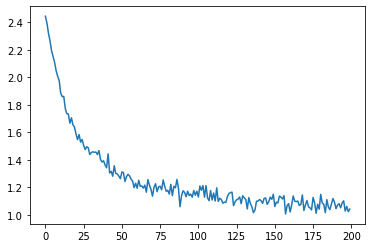

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [19]:
from namsorclient import NamsorClient
from namsorclient.country_codes import CountryCodes
from namsorclient.request_objects import *

# Create an instance of NamsorClient
client = NamsorClient("")

res = client.parseName("klocek Andrzej")
gender = client.gender(res.first_last_name.first_name,res.first_last_name.last_name).likely_gender
print(res.first_last_name)
print(gender)

LN1FN1
First Name: Andrzej | Last Name: klocek
male


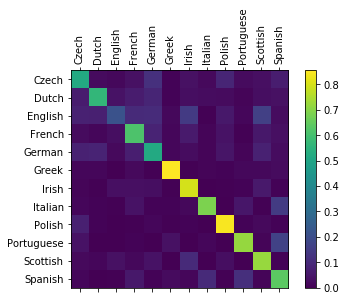

In [46]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [56]:
def predict(input_line, n_predictions=1):# only top 
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])


In [57]:
# Testing 
name = 'Rutkowska Malgorzata'
FullName= client.parseName(name)
gender = client.gender(FullName.first_last_name.first_name,FullName.first_last_name.last_name).likely_gender
print('First Name :',FullName.first_last_name.first_name)
print('Last Name :',FullName.first_last_name.last_name)
print('Gender :',gender)
print(predict(FullName.first_last_name.last_name))

LN1FN1
First Name : Malgorzata
Last Name : Rutkowska
Gender : female

> Rutkowska
(-0.30) Polish
None
